## Import libraries

In [127]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

# Import forest inventory data

In [77]:
forest_1 = gpd.read_file("Clipped/FAB_Clip.shp")
forest_2 = gpd.read_file("Clipped/ForstBW_Clip.shp")

In [79]:
forest_1.head()

,OBJECTID_1,distrikt,abteilung,revier,bestand,ba1,ba_p_1,ba2,ba_p_2,ba3,...,ba4,ba_p_4,ba5,ba6,ba_p_5,ba_p_6,globalid,SHAPE_Leng,SHAPE_Area,geometry
0,102,9,8,5,d4,Dgl,95,Bu,5,Bi,...,ELä,0,Fi,Ta,0,0,{8270B2EE-9F85-40FF-B384-B106F9A26F4C},455.194691,13689.624493,"POLYGON ((441718.054 5401123.789, 441720.01 54..."
1,99,21,6,4,d2,Dgl,95,BAh,5,Bu,...,EKa,0,Ei,Fi,0,0,{E9958FB6-A492-4F25-BF8B-3F2A34F0E187},372.568392,7934.144329,"POLYGON ((442493.363 5397216.409, 442490.039 5..."
2,227,5,10,3,hW,Lbh,100,None,0,None,...,None,0,None,None,0,0,{027DE92B-388C-4DC4-BAF9-04EC9677C2C0},1022.381385,12529.987465,"POLYGON ((446897.8 5399329.301, 446878.67 5399..."
3,21,5,6,3,b10/2,Lbh,100,Bu,0,Ta,...,None,0,None,None,0,0,{0BA265BD-74FD-4FEF-8EFE-B9F978CCA109},629.994495,19961.880803,"POLYGON ((447177.344 5400771.113, 447172.54 54..."
4,210,1,28,2,r5,Fi,100,Kie,0,Ta,...,Vb,0,None,None,0,0,{F3F726D3-8680-480D-B525-CCF1B6CC397E},230.141169,2118.832750,"POLYGON ((448131.95 5393361.91, 448129.22 5393..."


# Data Cleaning

In [82]:
forest_2 = forest_2.dropna(subset=['LWET_TEXT'])

In [84]:
forest_2.isnull().sum()

OBJECTID_1     0
OBJEKTART      0
NUART         70
WEFLKZ         0
STICHTAG       0
LWET_TEXT      0
SHAPE_Leng     0
SHAPE_Area     0
geometry       0
dtype: int64

## Tree Spicies

In [87]:
code_to_name = {
    "Fi": "Fichten-Mischwald",
    "Dgl": "Douglasien-Mischwald",
    "Bu": "Buchen-Laubwald",
    "REi": "Traubeneichenwald",
    "Kie": "Kiefernwald",
    "Lbh": "Laubholz",
    "BAh": "Buchen-Ahornwald",
    "REr": "Stieleichenwald",
    "Wei": "Weichlaubwald",
    "HPa": "Hainbuchewald",
    "Ei": "Eichenwald",
    "Rob": "Robinienwald",
    "Ndh": "Nadelholz",
    "sNb": "Sonstige Nadel- oder Blätterwald"
}

In [89]:
forest_1["spicies"] = forest_1["ba1"].map(code_to_name)
forest_2["spicies"] = forest_1["ba1"].map(code_to_name)

In [91]:
# same coordinate system
forest_2 = forest_2.to_crs(forest_1.crs)

# Make sure both GeoDataFrames have the same columns
combined_gdf = pd.concat([forest_1, forest_2], ignore_index=True)

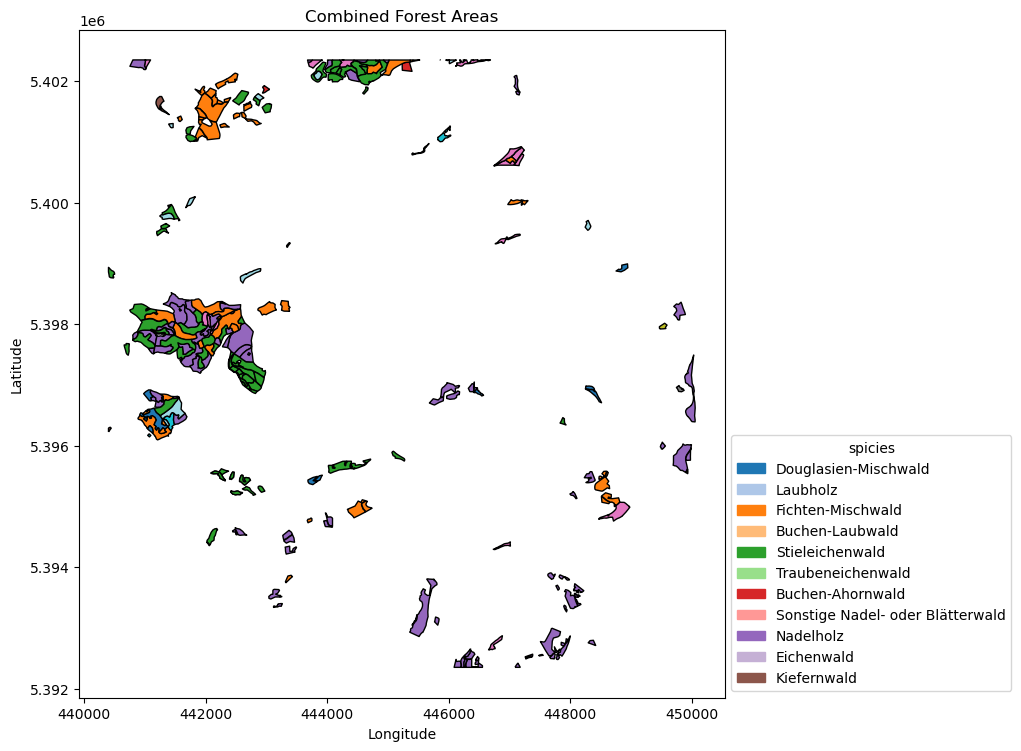

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Plot and get the axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot GeoDataFrame by 'LWE1_TEXT' column
combined_gdf.plot(
    ax=ax,
    edgecolor='black',
    column='spicies',
    legend=False,  # We'll add a custom legend
    cmap='tab20'   # You can choose other colormaps like 'Set1', 'Paired', etc.
)

# Create legend handles manually
unique_categories = combined_gdf['spicies'].unique()
colors = plt.cm.tab20.colors  # Change if using a different colormap

patches = []
for i, category in enumerate(unique_categories):
    color = colors[i % len(colors)]  # Loop over colormap if more categories than colors
    patch = mpatches.Patch(color=color, label=category)
    patches.append(patch)

# Add legend
plt.legend(handles=patches, title="spicies", loc='lower left', bbox_to_anchor=(1, 0))

# Add titles and labels
plt.title("Combined Forest Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

## Tree Spicies- Imbalance Classes

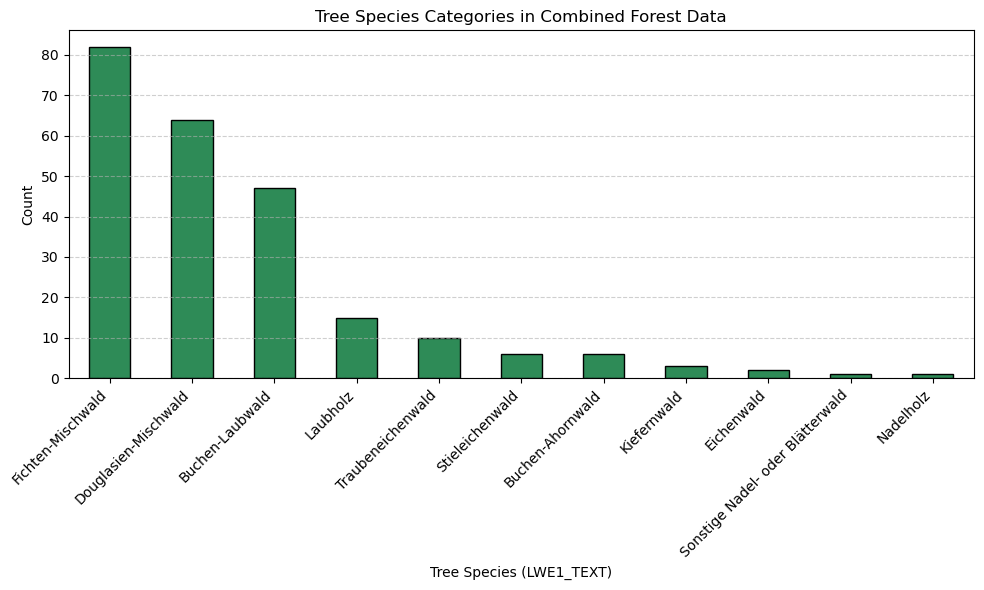

In [132]:
# Count occurrences of each category
category_counts = combined_gdf['spicies'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='seagreen', edgecolor='black')

plt.title("Tree Species Categories in Combined Forest Data")
plt.xlabel("Tree Species (LWE1_TEXT)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Count occurrences of each category
category_counts = combined_gdf['LWE1_TEXT'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='seagreen', edgecolor='black')

plt.title("Tree Species Categories in Combined Forest Data")
plt.xlabel("Tree Species (LWE1_TEXT)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [151]:
combined_gdf.to_file("union_output2.shp", driver="ESRI Shapefile", encoding="utf-8")

C:\Users\USER\anaconda3\envs\spatial-data-science\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field STICHTAG create as date field, though DateTime requested.
  ogr_write(
C:\Users\USER\anaconda3\envs\spatial-data-science\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Leng' to 'SHAPE_Le_1'
  ogr_write(
C:\Users\USER\anaconda3\envs\spatial-data-science\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Area' to 'SHAPE_Ar_1'
  ogr_write(


# Under-Sampling data

## Generate Random Points Within a Polygon

In [97]:
def generate_random_points_in_polygon(polygon, num_points):
    """Generates random points within a given polygon."""
    minx, miny, maxx, maxy = polygon.bounds
    points = []

    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)

    return points

## Calculate Balanced Sample Sizes per Category

In [99]:
def get_balanced_sample_counts(gdf, category_column, total_samples):
    """Returns a dict of how many points to sample per category to minimize class imbalance."""
    categories = gdf[category_column].value_counts().index
    n_categories = len(categories)
    samples_per_category = total_samples // n_categories

    return {cat: samples_per_category for cat in categories}

## Generate the Points and Assign Tree Species

In [101]:
def generate_points_balanced_by_species(polygons_gdf, category_column='LWE1_TEXT', total_samples=1000):
    """Generate points in polygons such that each species gets approx. equal number of points."""
    balanced_counts = get_balanced_sample_counts(polygons_gdf, category_column, total_samples)
    
    points_list = []

    for category, count in balanced_counts.items():
        # Filter polygons by category
        category_polygons = polygons_gdf[polygons_gdf[category_column] == category]
        
        # Split count evenly across all category polygons
        per_polygon_count = max(1, count // len(category_polygons))

        for _, row in category_polygons.iterrows():
            polygon = row.geometry
            species = row[category_column]

            pts = generate_random_points_in_polygon(polygon, per_polygon_count)
            for pt in pts:
                points_list.append({'geometry': pt, 'species': species})

    return gpd.GeoDataFrame(points_list, crs=polygons_gdf.crs)

In [109]:
# Assuming combined_gdf is your forest polygon GeoDataFrame with 'spicies' column
sampled_points_gdf = generate_points_balanced_by_species(combined_gdf, category_column='spicies', total_samples=1000)

# Optional: Save to file
# sampled_points_gdf.to_file("sampled_points.shp", driver="ESRI Shapefile", encoding="utf-8")

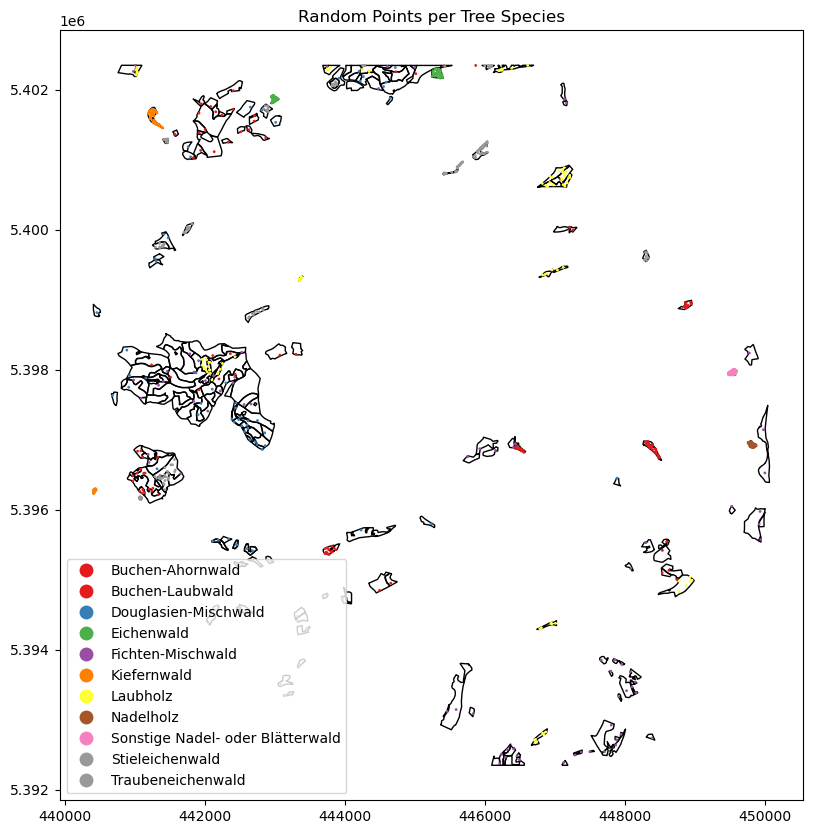

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))
combined_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
sampled_points_gdf.plot(ax=ax, column='species', markersize=1, legend=True, cmap='Set1')  # smaller points
plt.title("Random Points per Tree Species")
plt.show()

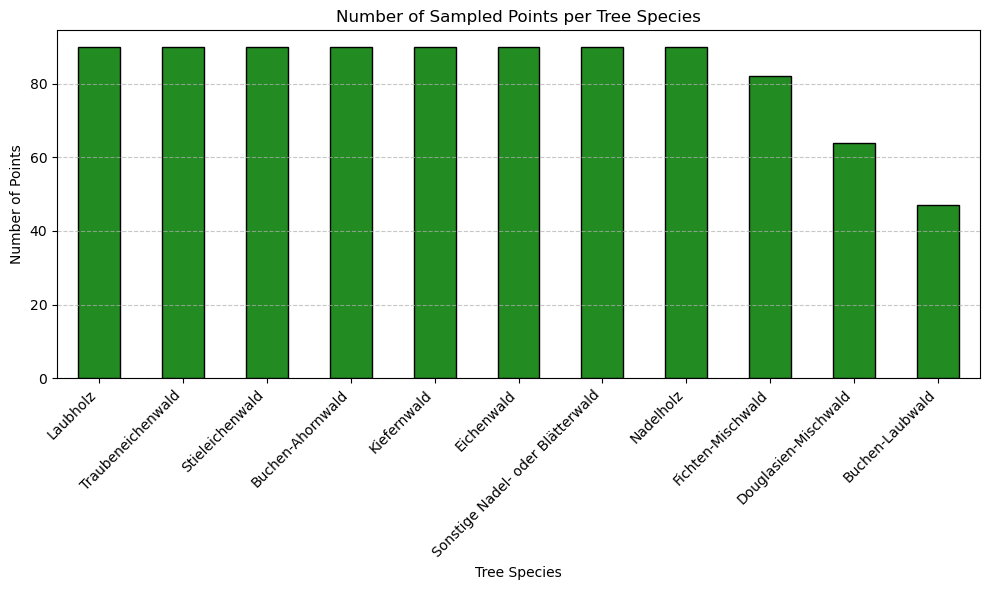

In [115]:
# Count points per species
species_counts = sampled_points_gdf['species'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='forestgreen', edgecolor='black')

plt.title("Number of Sampled Points per Tree Species")
plt.xlabel("Tree Species")
plt.ylabel("Number of Points")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()